<a href="https://colab.research.google.com/github/purvasingh96/Deep-Reinforcement-Learning/blob/master/2.%20Monte%20Carlo%20Methods/1.%20Teach%20an%20agent%20to%20play%20the%20game%20of%20Black%20Jack/Game_of_Black_Jack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [0]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

The code cell below creates an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [0]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [5]:
for i in range(4):
  state = env.reset()
  while True:
    print('State : ', state)
    action = env.action_space.sample()
    print('action : ', action)
    state, reward, done, info = env.step(action)
    print('State, reward, done, info : ', state, reward, done, info)
    if done:
      print('End game reward: ', reward)
      print('You win!') if reward > 0 else print('You lost')
      print('===============================================================')
      break

State :  (11, 10, False)
action :  0
State, reward, done, info :  (11, 10, False) -1.0 True {}
End game reward:  -1.0
You lost
State :  (14, 7, False)
action :  0
State, reward, done, info :  (14, 7, False) 1.0 True {}
End game reward:  1.0
You win!
State :  (15, 6, False)
action :  0
State, reward, done, info :  (15, 6, False) -1.0 True {}
End game reward:  -1.0
You lost
State :  (11, 1, False)
action :  1
State, reward, done, info :  (17, 1, False) 0.0 False {}
State :  (17, 1, False)
action :  1
State, reward, done, info :  (22, 1, False) -1.0 True {}
End game reward:  -1.0
You lost



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [0]:
def generate_episode_from_limit_stochastic(black_jack_env):
  episodes = []
  state = black_jack_env.reset()
  while True:
    probs = [0.8, 0.2] if state[0]>18 else [0.2, 0.8]
    action = np.random.choice(np.arange(2), p=probs)
    next_state, reward, done, info = black_jack_env.step(action)
    episodes.append((state, action, reward))
    state=next_state
    if done:
      break
  return episodes

In [54]:
for i in range(4):
    print(generate_episode_from_limit_stochastic(env))

[((13, 9, False), 1, -1.0)]
[((14, 6, False), 1, 0.0), ((21, 6, False), 1, -1.0)]
[((10, 3, False), 1, 0.0), ((14, 3, False), 1, 0.0), ((20, 3, False), 1, -1.0)]
[((9, 6, False), 0, 1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [55]:
x = np.array([1, 2, 3, 4, 5, 6])
print(x[:-1]) # [1 2 3 4 5]
print(x[1:]) #[2 3 4 5 6]

[1 2 3 4 5]
[2 3 4 5 6]


In [0]:
# predicting action-value
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
  sum_of_returns = defaultdict(lambda: np.zeros(env.action_space.n))
  N_visits = defaultdict(lambda: np.zeros(env.action_space.n))
  Q = defaultdict(lambda: np.zeros(env.action_space.n))

  for i in range(1, num_episodes+1):
    if i % 1000 == 0:
            print("\rEpisode {}/{}.".format(i, num_episodes), end="")
            sys.stdout.flush()
    # generate an episode
    episode = generate_episode(env)
    # episode = {S, A, R}
    states, actions, rewards = zip(*episode)
    # geneate discount
    '''
        This discounts array is the amount by which we wanna discount each consequent reward ie.
        discounts = [1,gamma, gamma^2, gamma^3.....] 
        then we compute the total return Gt= Rt+1 *1 + Rt+2 * gamma + Rt+3 * gamma^2 +...
    '''
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    # update sum of returns, n_visits, action-value
    for i, state in enumerate(states):
      sum_of_returns[state][actions[i]] += sum(rewards[i:]*discounts[:-(i+1)])
      N_visits[state][actions[i]] += 1.0
      Q[state][actions[i]] = sum_of_returns[state][actions[i]] / N_visits[state][actions[i]]
  
  return Q


Episode 500000/500000.

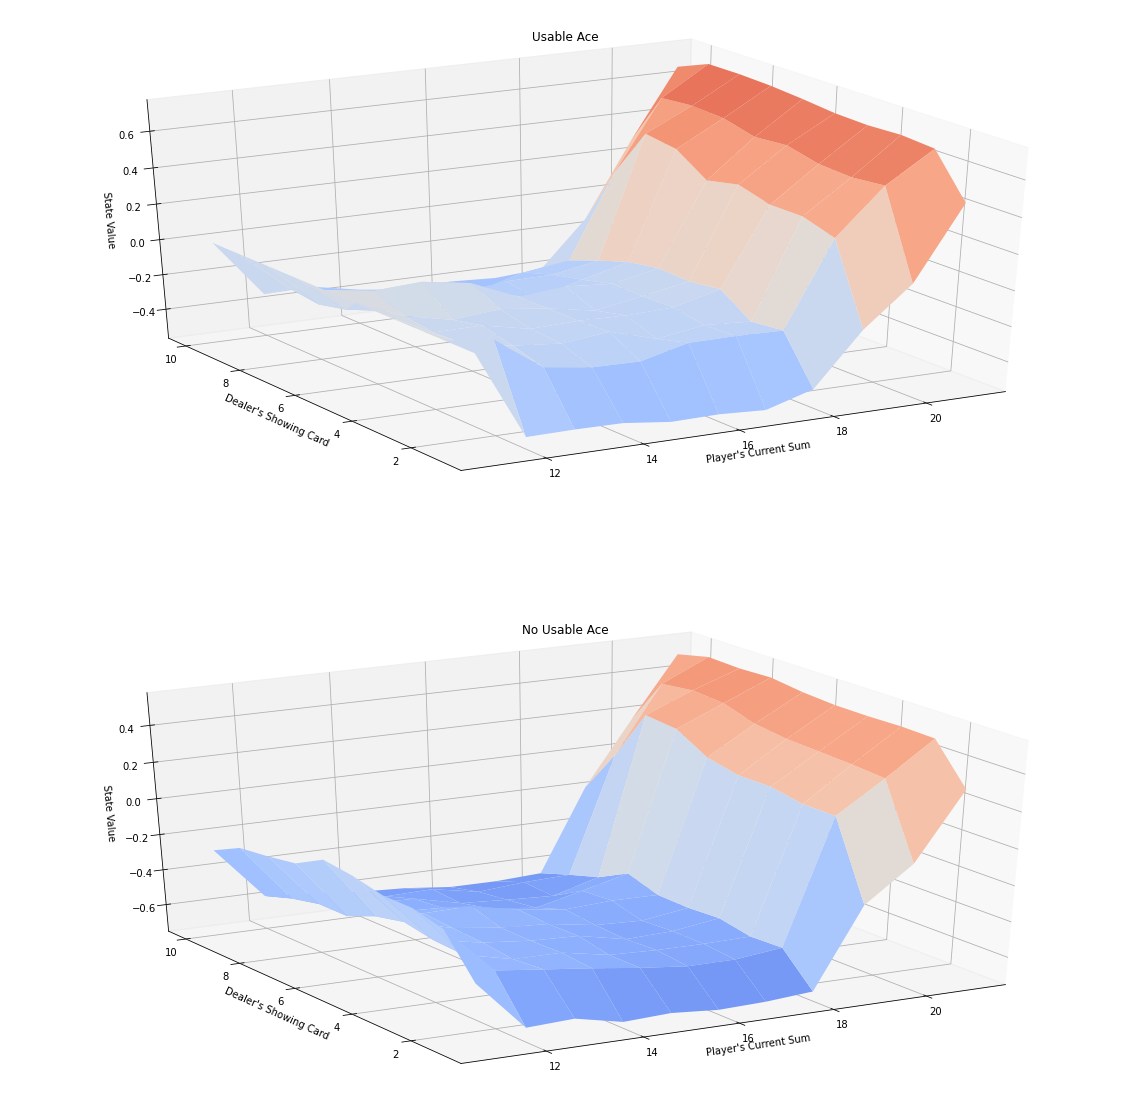

In [59]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [0]:
def generate_episode_from_Q(env, Q, epsilon, nA):
  episode = []
  state = env.reset()
  while True:
    action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) if state in Q else env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    episode.append((state, action, reward))
    state = next_state
    if done:
      break
  return episode


In [0]:
def get_probs(Q_s, epsilon, nA):
  policy_s = np.ones(nA) * epsilon / nA
  best_a = np.argmax(Q_s)
  policy_s[best_a] = 1-epsilon + (epsilon/nA)
  return policy_s
  

In [0]:
def update_Q(env, episode, Q, alpha, gamma):
  states, actions, rewards = zip(*episode)
  discounts = np.array([gamma**i for i in range(len(rewards)+1)])
  for i, state in enumerate(states):
    old_Q = Q[state][actions[i]]
    Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
  return Q

In [0]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=0.99999, eps_min=0.05):
  nA = env.action_space.n

  Q = defaultdict(lambda: np.zeros(nA))
  epsilon = eps_start

  for i_episode in range(1, num_episodes+1):
    if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
    epsilon = max(epsilon*eps_decay, eps_min)
    episode = generate_episode_from_Q(env, Q, epsilon, nA)
    Q = update_Q(env, episode, Q, alpha, gamma)
  
  policy = dict((k, np.argmax(Q)) for k, v in Q.items())
  return policy, Q




In [77]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.02)

Episode 500000/500000.

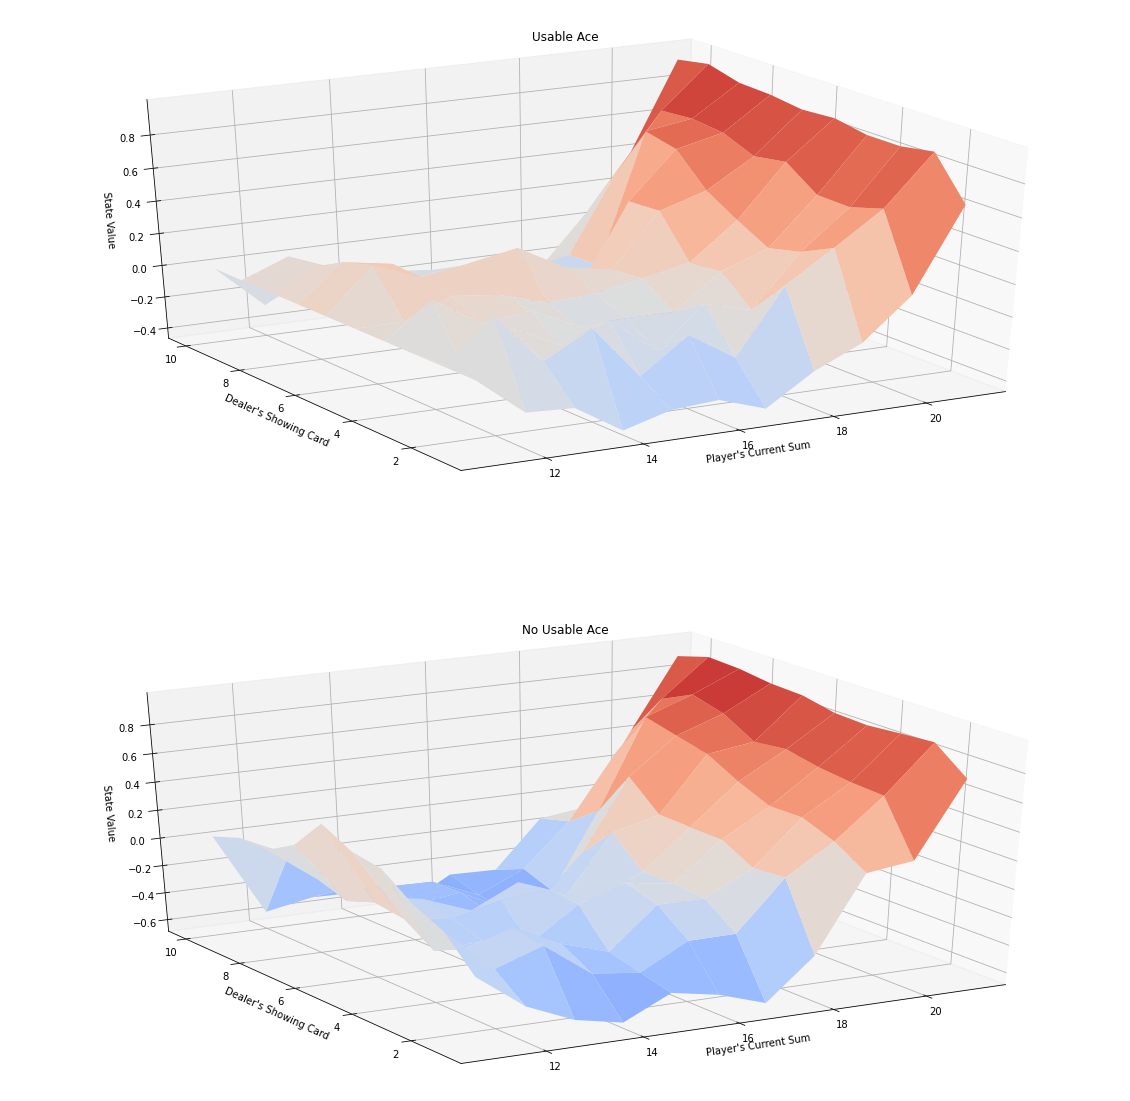

In [78]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

In [82]:
for i in range(10):
  state = env.reset()
  while True:
    print('State : ', state)
    action = env.action_space.sample()
    print('action : ', action)
    state, reward, done, info = env.step(action)
    print('State, reward, done, info : ', state, reward, done, info)
    if done:
      print('End game reward: ', reward)
      print('You win!') if reward > 0 else print('You lost')
      print('===============================================================')
      break

State :  (18, 10, False)
action :  1
State, reward, done, info :  (28, 10, False) -1.0 True {}
End game reward:  -1.0
You lost
State :  (12, 10, False)
action :  1
State, reward, done, info :  (14, 10, False) 0.0 False {}
State :  (14, 10, False)
action :  1
State, reward, done, info :  (24, 10, False) -1.0 True {}
End game reward:  -1.0
You lost
State :  (14, 8, True)
action :  0
State, reward, done, info :  (14, 8, True) -1.0 True {}
End game reward:  -1.0
You lost
State :  (5, 2, False)
action :  0
State, reward, done, info :  (5, 2, False) -1.0 True {}
End game reward:  -1.0
You lost
State :  (9, 4, False)
action :  1
State, reward, done, info :  (13, 4, False) 0.0 False {}
State :  (13, 4, False)
action :  0
State, reward, done, info :  (13, 4, False) 1.0 True {}
End game reward:  1.0
You win!
State :  (16, 2, False)
action :  1
State, reward, done, info :  (19, 2, False) 0.0 False {}
State :  (19, 2, False)
action :  0
State, reward, done, info :  (19, 2, False) 1.0 True {}
End g